## Decision Trees

Decision trees are widely used models for classification and regression tasks.  Eseentially, they learn a hierarchy of if/else questions, leading to a decision.

These questions are similar to the questions you might ask in a game of *20 Questions*:

In [2]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn
from IPython.display import display
import mglearn

# Don't display deprecation warnings
import warnings
warnings.filterwarnings('ignore')

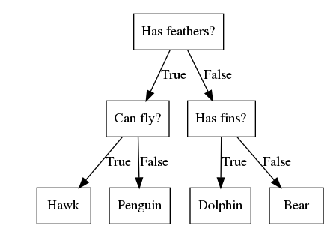

In [3]:
mglearn.plots.plot_animal_tree()

In this illustration, each node in the tree either represents a question or a leaf that contains the answer.  The edges connect the answers to a question with the next question you would ask.

In machine learning parlance, we built a model to distinguish between 4 classes of animals (*hawks, penguins, dolphins, and bears*) using 3 features (*'has feathers', 'can fly', and 'has fins'*).

### Building Decision Trees

We'll go through the process of building a decision tree for a 2D classification dataset, *two-moons*, that consists of 2 half-moon shapes, with each class consisting of 75 data points.

Learning a decision tree means learning the sequence of if/else questions that gets us to the true answer most quickly.  In machine learning settings, these questions are called *tests*.  Usually data does not come in the form of yes/no questions like in the animal tree, but instead represented as continuous features.  The tests that are used on continuous data are of the form *Is Feature i larger than value a?*

To build a tree, the algorithm searches over all possible tests and finds the one that is most informative about the target variable.  

For the first test, splitting the dataset horizontally at x[1]=0.0596 yields the most information.  The root node represents the entire data set, corresponding to 50 points belonging to class 0 and 50 points belonging to class 1.  

If the test (*X[1] <= 0.0596*) is true, a point is assigned to the left node, which contains 2 points belonging to class 0 and 32 points belonging to class 1.

If the test is false, a point is assigned to the right node, which contains 48 points belonging to class 0 and 18 points belonging to class 1.  

Even though the first split did a good job of separating the two classes, the bottom region still contains points belonging to class 0 and the top region still contains points belonging to class 1.

![Decision Tree (Depth=1)](img/d1decisiontree.png)

We can build a more accurate model by repeating the process of looking for the best test in both regions.

![Decision Tree (Depth=2)](img/d2decisiontree.png)

The recursive process yields a binary tree of decisions, with each node containing a test.  Alternatively, we can think of each test as splitting the part of the data that is currently being considered along one axis.  

This yields a view of the algorithm as building a hierarchical position.  As each test concerns only a single feature, the regions in the resulting partition always have axis-parallel boundaries.

The recursive partitioning of the data is repeated until each region in the partition only contains a single target value.  A leaf of the tree that contains data points that all share the same target value is called *pure*.

![Decision Tree (Depth=Final)](img/d9decisiontree.png)

A prediction on a new data point is made by checking which region of the partition of the feature space the point lies in, and then predicting the majority target in that region.  The region can be found by traversing the tree and going left or right depending on whether the test is fulfilled or not.

It is also possible to use trees for regression tasks using exactly the same technique.  To make a prediction, we traverse the tree based on the tests in each node and find the leaf the new data point falls into.  The output for the data point is the mean target of the training points in this leaf.

### Controlling Complexity of Decision Trees

Typically, building a tree until all leaves are pure leads to a very complex and highly overfit model.  The presence of pure leaves means the tree is 100% accurate on the training set.  

There are two common strategies to prevent overfitting:
- *Pre-pruning* = stopping the creation of the tree early
- *Post-pruning* = removing or collapsing nodes that contain little information

Possible criteria for pre-pruning include limiting the maximum depth of the tree, limiting the maximum number of leaves, or requiring a minimum number of points in a node to keep splitting it.

Decision trees in *scikit-learn* are implemented in the *DecisionTreeRegressor* and *DecisionTreeClassifier* classes.  *scikit-learn* only implements pre-pruning, not post-pruning.

Here, we'll look at the effect of pre-pruning in more detail on the Breast Cancer dataset.  We'll also fix the *random_state* in the tree, used for tie-breaking internally.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

from sklearn.tree import DecisionTreeClassifier

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                   stratify=cancer.target, random_state=42)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.937


As expected, the accuracy on the training set is 100%, because the leaves are pure.  Now, we'll try applying pre-pruning to the tree by setting *max_depth=4*.

In [5]:
tree = DecisionTreeClassifier(random_state=0, max_depth=4)
tree.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.951


By pre-pruning the tree, we get a lower accuracy on the training set, but a better accuracy on the test set.

### Analyzing Decision Trees

We can visualize the tree using the *export_graphviz* function from the *tree* module.  This writes a file to the *.dot* file format, which is a text file format for storing graphs.

In [6]:
from sklearn.tree import export_graphviz

export_graphviz(tree, out_file="tree.dot", class_names=["malignant", "benign"],
               feature_names=cancer.feature_names, impurity=False, filled=True)

Now, we can read this file and visualize it using the *graphviz* module.

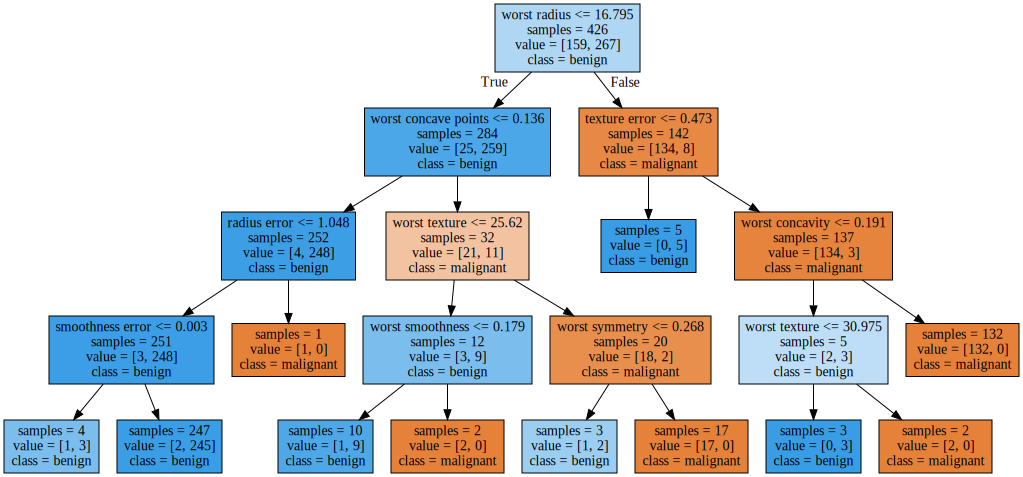

In [7]:
import graphviz

with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

The visualization of the tree provides a great in-depth view of how the algorithm makes predictions.  This makes it a good example of a machine learning algorithm that is easily explained to non-experts.  

### Feature Importance in Trees

Instead of looking at the whole tree, which can be taxing, there are some useful properties that we can derive to summarize the workings of the tree.  

The most commonly used summary is *feature importance*, which rates how important each feature is for the decision a tree makes.  It is a number between 0 and 1 for each feature, where 0 means "not used at all" and 1 means "perfectly predicts the target".  The feature importances always sum to 1.

In [8]:
print("Feature importances:")
print(tree.feature_importances_)

Feature importances:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01019737 0.04839825
 0.         0.         0.0024156  0.         0.         0.
 0.         0.         0.72682851 0.0458159  0.         0.
 0.0141577  0.         0.018188   0.1221132  0.01188548 0.        ]


We can visualize the feature importances in a way that is similar to the way we visualize the coefficients in the linear model.

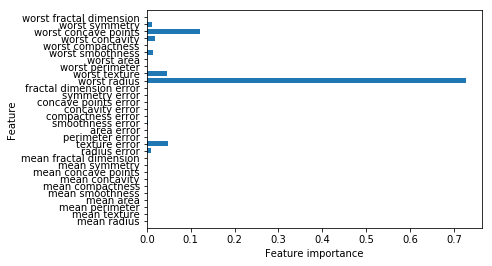

In [9]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    
plot_feature_importances_cancer(tree)

Here, we see that the feature used in the top split (*worst radius*) is by far the most important feature.  

Note that just because a feature has a low value in *feature_importance_*, it doesn't mean that this feature is uninformative.  It only means the feature was not picked by the tree, likely because another feature encodes the same information.

The feature importances tell us that *worst radius* is important, but not whether a high radius is indicative of a sample being benign or malignant.  In fact, there might not be such a simple relationship between features and a class, as we can see in this example:

Feature importances: [0. 1.]


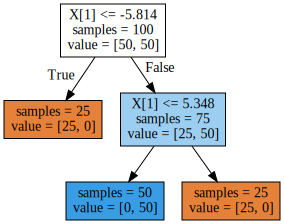

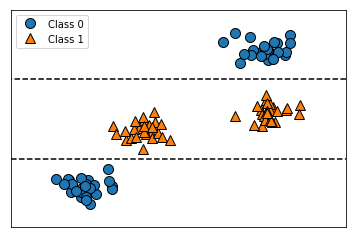

In [10]:
tree = mglearn.plots.plot_tree_not_monotone()
display(tree)

This plot shows a dataset with 2 features and 2 classes.  Here, all the information is contained in X[1], and X[0] is not used at all.  But, the relation between X[1] and the output class is not monotonous.  So we can't just say that "a high value of X[1] means class 0, and a low value means class 1".  

### DecisionTreeRegressors

The usage and analysis of regression trees is very similar to that of classification trees.  

One particular property that is important to understand about regression trees, however, is that tree-based regression models are not able to *extrapolate*, or make predictions outside of the range of the training data.

Here, we look at the dataset of historical computer memory (RAM) prices.

Text(0, 0.5, 'Price in $/Mbyte')

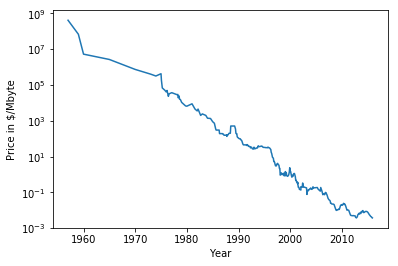

In [11]:
import os
ram_prices = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, "ram_price.csv"))

plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte")

Note that with the y-axis on a logarithmic scale, the relation seems to be quite linear.

We will make a forecast for the years after 2000 using the historical data up to that point, with the date as our only feature.  We will compare 2 simple models: *DecisionTreeRegressor* and *LinearRegression*.  We rescale the prices using a logarithm so that the relationship is relatively linear.  This actually doesn't make a big difference for the *DecisionTreeRegressor*, but it makes a big difference for *LinearRegression*.

After training the models and making predictions, we apply the exponential map to undo the logarithm transform.  We make predictions on the whole dataset for visualization purposes here, but for a quantitative evaluation we would only consider the test set.

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Use historical data to forecast prices after the year 2000
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

# Predict prices based on date
X_train = data_train.date[:, np.newaxis]

# We use a log transform to get a simpler relationship of data to target
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor(max_depth = 3).fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

# Predict on all data
X_all = ram_prices.date[:, np.newaxis]

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

# Undo log transform
price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

Here, we compare the predictions of the decision tree and linear regression model with the ground truth.

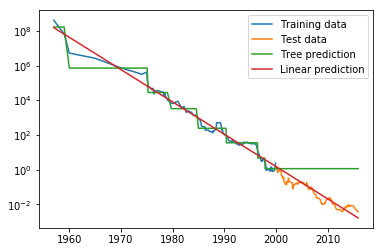

In [15]:
plt.semilogy(data_train.date, data_train.price, label="Training data")
plt.semilogy(data_test.date, data_test.price, label="Test data")
plt.semilogy(ram_prices.date, price_tree, label="Tree prediction")
plt.semilogy(ram_prices.date, price_lr, label="Linear prediction")
plt.legend()

Here, the difference between the models is quite striking.  The linear model approximates the data with a line.  The tree model makes perfect predictions on the training data, but once we leave the date range for which the model has data, the model simply keeps predicting the last known point.

The tree has no ability to generate new responses.  This shortcoming applies to all models based on trees.

### Strengths, Weaknesses, and Parameters

The parameters that control model complexity in decision trees are the pre-pruning parameters that top the building of the tree before it is fully developed.  Usually setting one of the strategies (*max_depth*, *max_leaf_nodes*, or *min_samples_leaf*) is sufficient to prevent overfitting.

Decision trees have 2 major advantages over many other algorithms:
- The resulting model can be visualized and understood by nonexperts.
- The algorithms are completely invariant to scaling of the data.  In particular, decision trees work well when you have features that are on completely different scales, or a mix of binary and continuous features.

The main downsides of decision trees is that even with the use of pre-pruning, they tend to overfit and provide poor generalization performance.  Therefore, ensembles of decision trees are usually used in place of a single decision tree.